In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import scipy.signal as signal
import os
import seaborn as sns
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [2]:
main_path = r"Programowanie_Ron_wyniki_AmpOn=1.2_dtOn=0.015_1.csv"
data = pd.read_csv(main_path)
data

,Timestamp,No. pulses,No. Test,R,Succes,dt_Ron,Amp_RonR,q,E_memristor,State
0,1.676315e+09,0,0,736.349961,False,0.015,1.2,0.000000,0.000000,R_off
1,1.676315e+09,1,0,3.322891,False,0.015,1.2,0.002462,0.001032,Unknown
2,1.676315e+09,2,0,2.664260,True,0.015,1.2,0.002567,0.001002,R_on
3,1.676315e+09,0,1,1267.767368,False,0.015,1.2,0.000000,0.000000,R_off
4,1.676315e+09,1,1,2.491987,True,0.015,1.2,0.002442,0.001024,R_on
...,...,...,...,...,...,...,...,...,...,...
500,1.676316e+09,1,98,2.200976,True,0.015,1.2,0.002681,0.000949,R_on
501,1.676316e+09,0,99,815.573235,False,0.015,1.2,0.000000,0.000000,R_off
502,1.676316e+09,1,99,2.284246,True,0.015,1.2,0.002654,0.000963,R_on
503,1.676316e+09,0,100,859.415191,False,0.015,1.2,0.000000,0.000000,R_off


In [3]:
data.columns = ["Time", "Pulses", "Tests",'R','isSucces','dt_Ron',
       'Amp_Ron', 'q', 'E_memristor', 'State']

In [4]:
data.columns

Index(['Time', 'Pulses', 'Tests', 'R', 'isSucces', 'dt_Ron', 'Amp_Ron', 'q',
       'E_memristor', 'State'],
      dtype='object')

In [5]:
data.head()

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State
0,1.676315e+09,0,0,736.349961,False,0.015,1.2,0.000000,0.000000,R_off
1,1.676315e+09,1,0,3.322891,False,0.015,1.2,0.002462,0.001032,Unknown
2,1.676315e+09,2,0,2.664260,True,0.015,1.2,0.002567,0.001002,R_on
3,1.676315e+09,0,1,1267.767368,False,0.015,1.2,0.000000,0.000000,R_off
4,1.676315e+09,1,1,2.491987,True,0.015,1.2,0.002442,0.001024,R_on


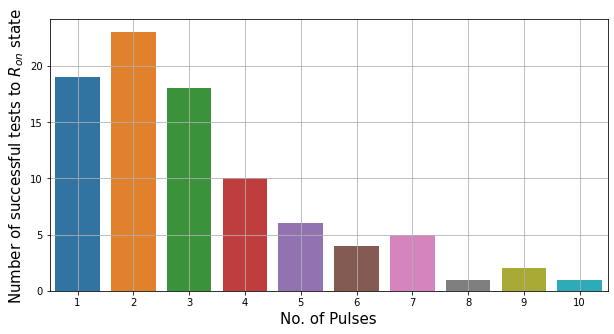

In [6]:

temp_data = data[data["isSucces"]==True].groupby(by="Pulses").count()
plt.figure(figsize=(10,5))
sns.barplot( x=temp_data.index,y="R", data=temp_data)
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)

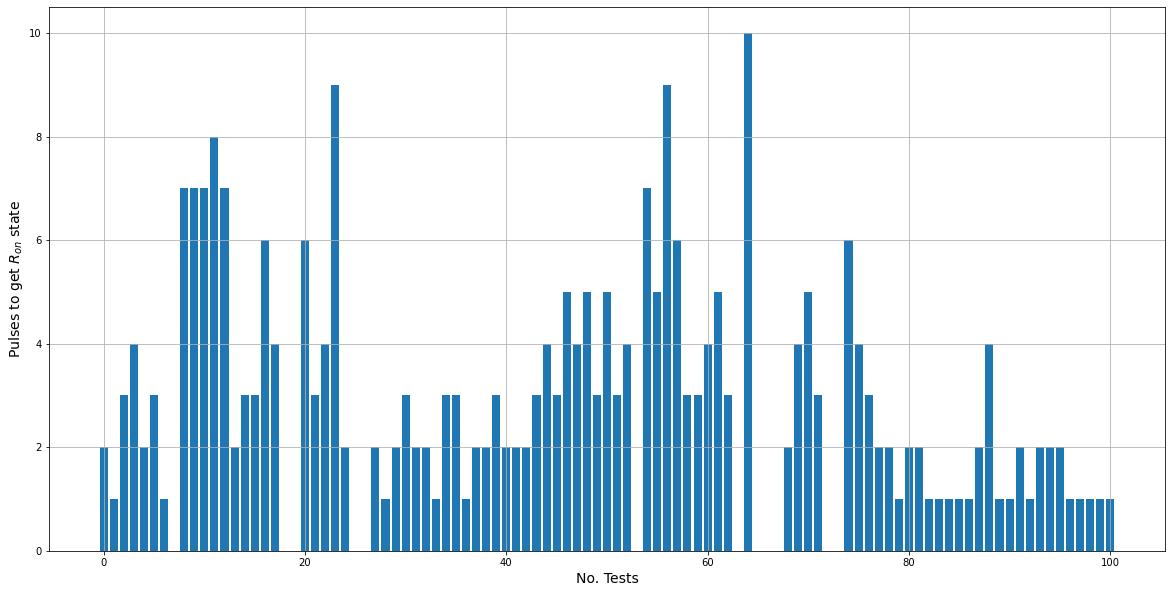

In [7]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Pulses"],width=0.8)
plt.xlabel("No. Tests",fontdict={'fontsize':14})
plt.ylabel("Pulses to get $R_{on}$ state",fontdict={'fontsize':14})
plt.grid(True)




In [8]:
data['Q_integrated'] = np.nan
data['E_integrated'] = np.nan



for i in data.index:
    if data.loc[i,"q"] == 0:
        data.loc[i,"Q_integrated"] = 0
    else:
        data.loc[i,"Q_integrated"] = data.loc[i-1,"Q_integrated"]+data.loc[i,"q"]
    if data.loc[i,"E_memristor"] == 0:
        data.loc[i,"E_integrated"] = 0
    else:
        data.loc[i,"E_integrated"] = data.loc[i-1,"E_integrated"]+data.loc[i,"E_memristor"]

data['Q_integrated']





0      0.000000
1      0.002462
2      0.005029
3      0.000000
4      0.002442
         ...   
500    0.002681
501    0.000000
502    0.002654
503    0.000000
504    0.002608
Name: Q_integrated, Length: 505, dtype: float64

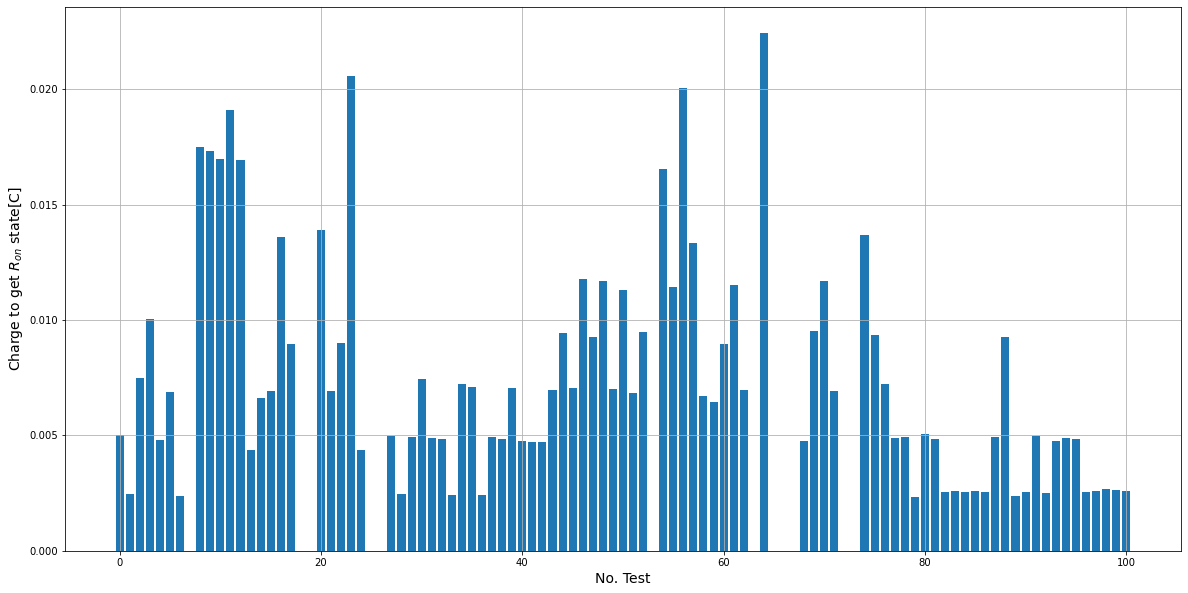

In [9]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Q_integrated"],width=0.8)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Charge to get $R_{on}$ state[C]",fontdict={'fontsize':14})
plt.grid(True)



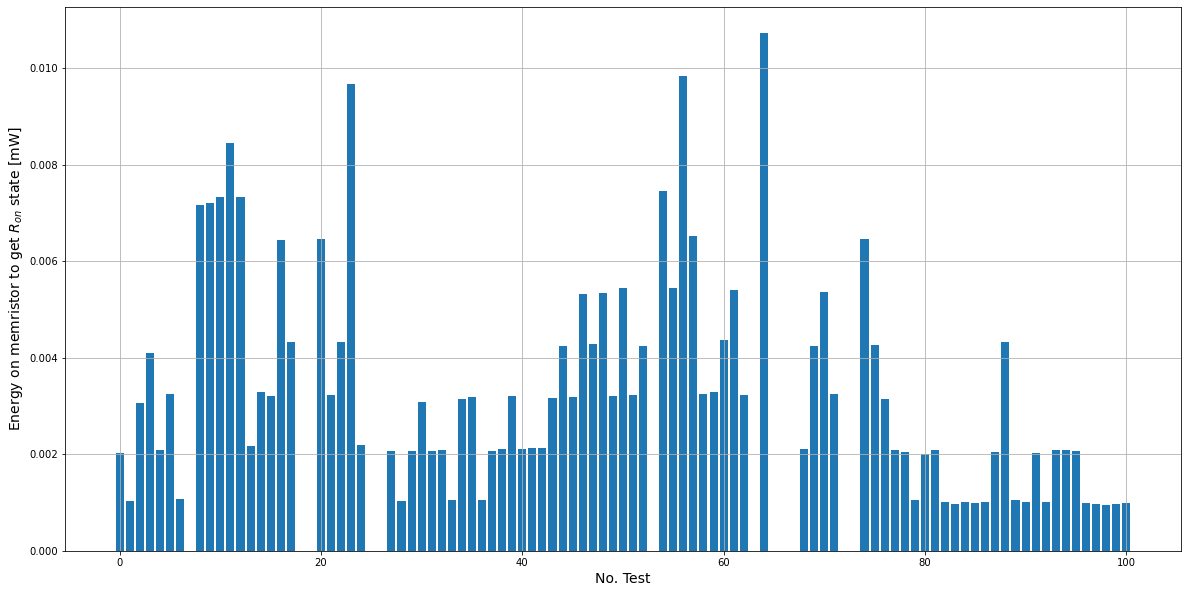

In [10]:

temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["E_integrated"],width=0.8,)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Energy on memristor to get $R_{on}$ state [mW]",fontdict={'fontsize':14})
plt.grid(True)


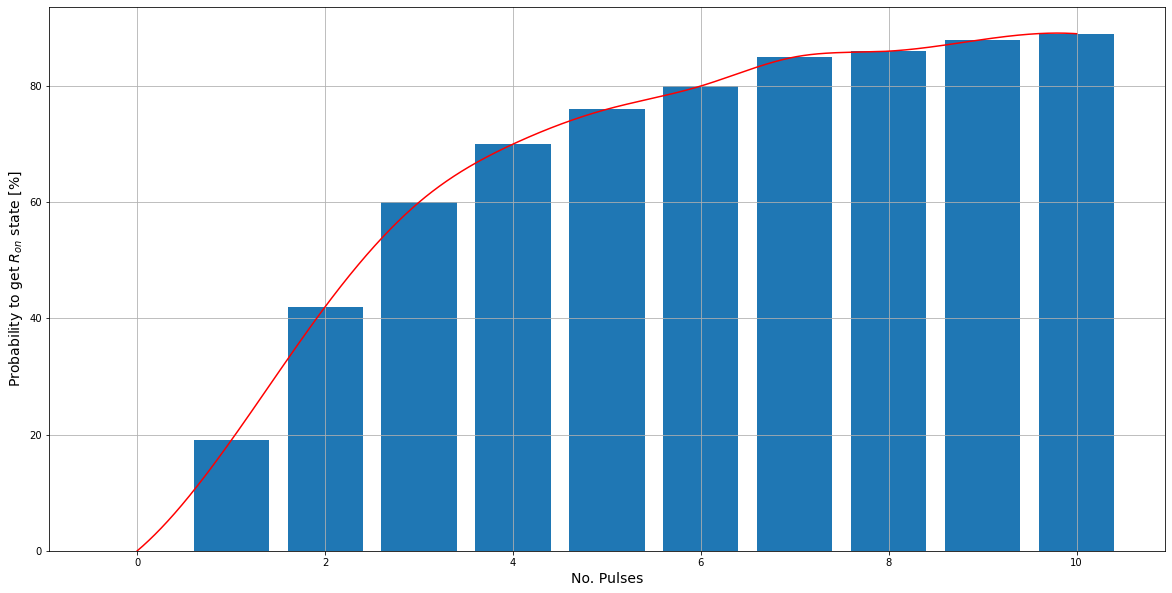

In [11]:
from scipy.interpolate import interp1d

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Pulses",as_index=False).count()
temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
temp_data.reset_index(inplace=True)
P = 0
for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P
x = temp_data['Pulses'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.bar(x=x, height=y,width=0.8)
plt.xlabel("No. Pulses",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='cubic')
plt.plot(x_i, cs(x_i),'r') 
#bla bla


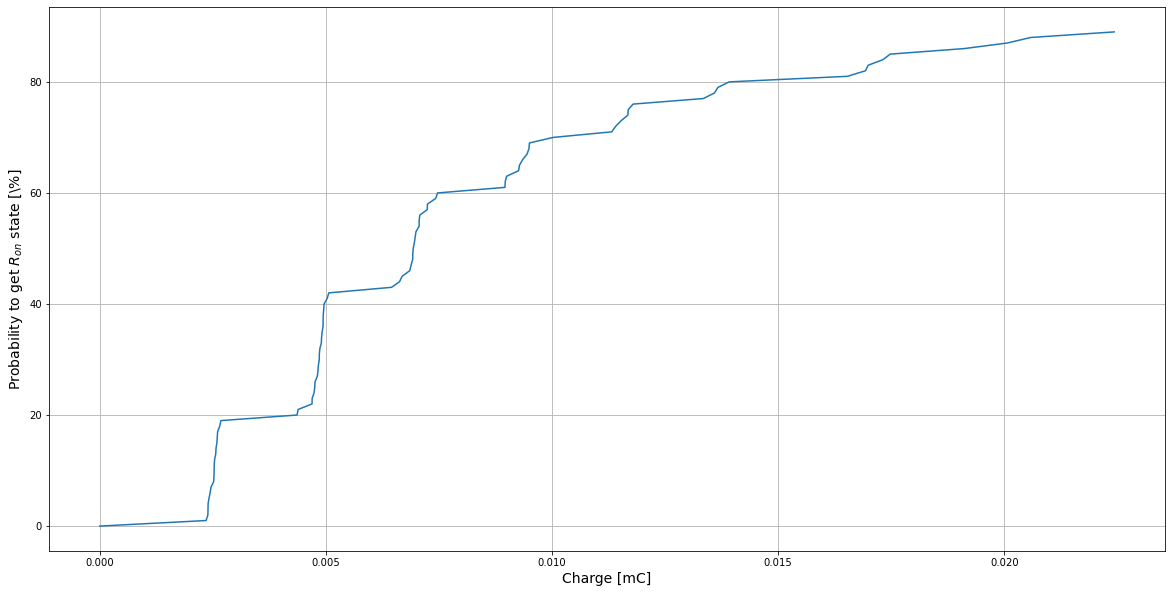

In [12]:

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Q_integrated",as_index=False).count()
temp_data.sort_values(by="Q_integrated",ascending=True,inplace=True)
temp_data.reset_index(drop=True,inplace=True)
temp_data

temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
P = 0

for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P

x = temp_data['Q_integrated'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel("Charge [mC]",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [\%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='previous')


t = data["R"] == "nan"
t = np.where(t==True)
data.iloc[t[0]]
data =data.drop(labels = t[0],axis=0).reset_index(drop=True)
data["R"] = data["R"].astype(np.float64)



#plt.plot(x_i, cs(x_i),'r')




In [13]:
data

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State,Q_integrated,E_integrated
0,1.676315e+09,0,0,736.349961,False,0.015,1.2,0.000000,0.000000,R_off,0.000000,0.000000
1,1.676315e+09,1,0,3.322891,False,0.015,1.2,0.002462,0.001032,Unknown,0.002462,0.001032
2,1.676315e+09,2,0,2.664260,True,0.015,1.2,0.002567,0.001002,R_on,0.005029,0.002034
3,1.676315e+09,0,1,1267.767368,False,0.015,1.2,0.000000,0.000000,R_off,0.000000,0.000000
4,1.676315e+09,1,1,2.491987,True,0.015,1.2,0.002442,0.001024,R_on,0.002442,0.001024
...,...,...,...,...,...,...,...,...,...,...,...,...
500,1.676316e+09,1,98,2.200976,True,0.015,1.2,0.002681,0.000949,R_on,0.002681,0.000949
501,1.676316e+09,0,99,815.573235,False,0.015,1.2,0.000000,0.000000,R_off,0.000000,0.000000
502,1.676316e+09,1,99,2.284246,True,0.015,1.2,0.002654,0.000963,R_on,0.002654,0.000963
503,1.676316e+09,0,100,859.415191,False,0.015,1.2,0.000000,0.000000,R_off,0.000000,0.000000


In [14]:
temp_data = data[data['State'] == "Unknown"]


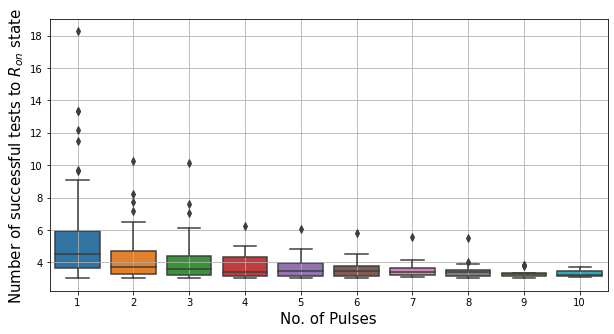

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)




In [16]:
temp_data = data[data['Pulses'] != 0]

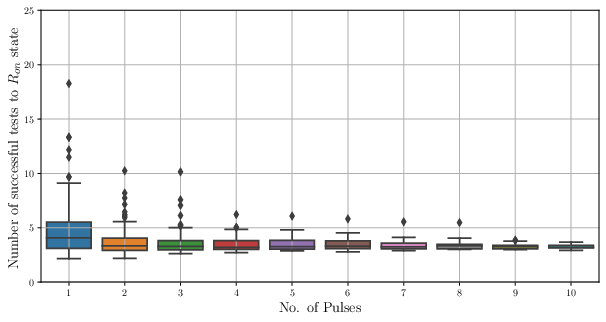

In [17]:


plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)
plt.ylim((0,25))
plt.savefig('histogram.pgf')

In [18]:
k = np.logical_and( temp_data["Pulses"]>=4, temp_data["R"]>=100 )
k = np.where(k==True)
temp_data.iloc[k[0]]
temp_data =temp_data.drop(labels = k[0],axis=0).reset_index(drop=True)
temp_data.max()


Time            1676315937.739678
Pulses                         10
Tests                         100
R                       18.263465
isSucces                     True
dt_Ron                      0.015
Amp_Ron                       1.2
q                        0.002681
E_memristor              0.001136
State                     Unknown
Q_integrated             0.024722
E_integrated             0.011063
dtype: object

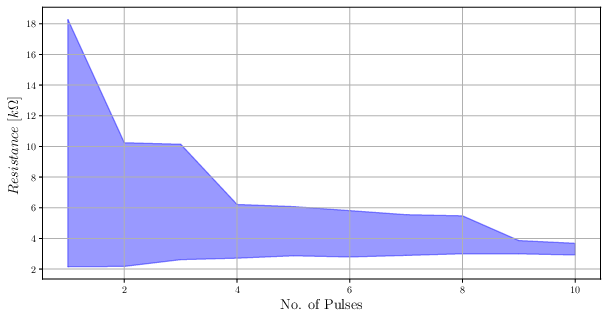

In [19]:
plt.figure(figsize=(10,5))
max = temp_data.groupby('Pulses').max()["R"]
min = temp_data.groupby('Pulses').min()["R"]
plt.fill_between(max.index, max, min, alpha=0.4, color='blue')
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("$Resistance\ [k\Omega]$ ", fontsize=15)
plt.grid(True)
#plt.ylim((0,25))

In [20]:
data[data['State']=="R_off"].min()

Time            1676314826.081133
Pulses                          0
Tests                           0
R                      185.639894
isSucces                    False
dt_Ron                      0.015
Amp_Ron                       1.2
q                             0.0
E_memristor                   0.0
State                       R_off
Q_integrated                  0.0
E_integrated                  0.0
dtype: object